In [179]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import shapiro
import scipy.stats as stats


In [180]:
#В процессе прохождения игры игроки встречаются с препятствием, которое не даёт сразу пройти на следующий уровень
#или совершить покупку в приложении.
#Первое препятствие было перемещено с 30-го на 40-й уровень.
#Анализируется влияние перемещения на количество игровых раундов.

#Данные получены от 90 189 игроков, которые установили игру во время проведения AB-теста. Переменные:
#userid - уникальный номер, который идентифицирует каждого игрока.
#версия - попал ли игрок в контрольную группу (gate_30 - препятствие на 30 уровне) или тестовую группу (gate_40 - препятствие на 40 уровне).
#sum_gamerounds - количество игровых раундов, сыгранных игроком в течение первой недели после установки
#удержания_1 - игрок вернулся и играл через 1 день после установки
#удержания_7 - игрок вернулся и играл через 7 дней после установки
#При установке игры, препятствие случайным образом устанавливалось на gate_30, либо на gate_40.

In [181]:
!git clone https://github.com/sirius-devel/datasets_for_studing2.git

fatal: destination path 'datasets_for_studing2' already exists and is not an empty directory.


In [182]:
path = "/content/datasets_for_studing2/cookie_cats.csv"

def load(path, info = True):

    import pandas as pd
    import io

    read = pd.read_csv(path)

    if info:
        if len(read) > 0:
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")

            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n",
                      len(read.select_dtypes("object").columns), "\n",
                      read.select_dtypes("object").columns.tolist(), "\n")
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n",
                      len(read.select_dtypes("integer").columns), "\n",
                      read.select_dtypes("integer").columns.tolist(), "\n")

            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n",
                      len(read.select_dtypes("float").columns), "\n",
                      read.select_dtypes("float").columns.tolist(), "\n")

            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n",
                      len(read.select_dtypes("bool").columns), "\n",
                      read.select_dtypes("bool").columns.tolist(), "\n")

        else:
            print("# Data did not read!")
        return read

ab = load(path, info = True)
ab.head()

Observation: 90189 Column: 5 

Object Variables: 
 1 
 ['version'] 

Integer Variables: 
 2 
 ['userid', 'sum_gamerounds'] 

Bool Variables: 
 2 
 ['retention_1', 'retention_7'] 



,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [186]:
#Сводная статистика по sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,49854.0


In [187]:
#Исследуем статистику для двух групп (обращает на себя внимание разница между максимумами данных).
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


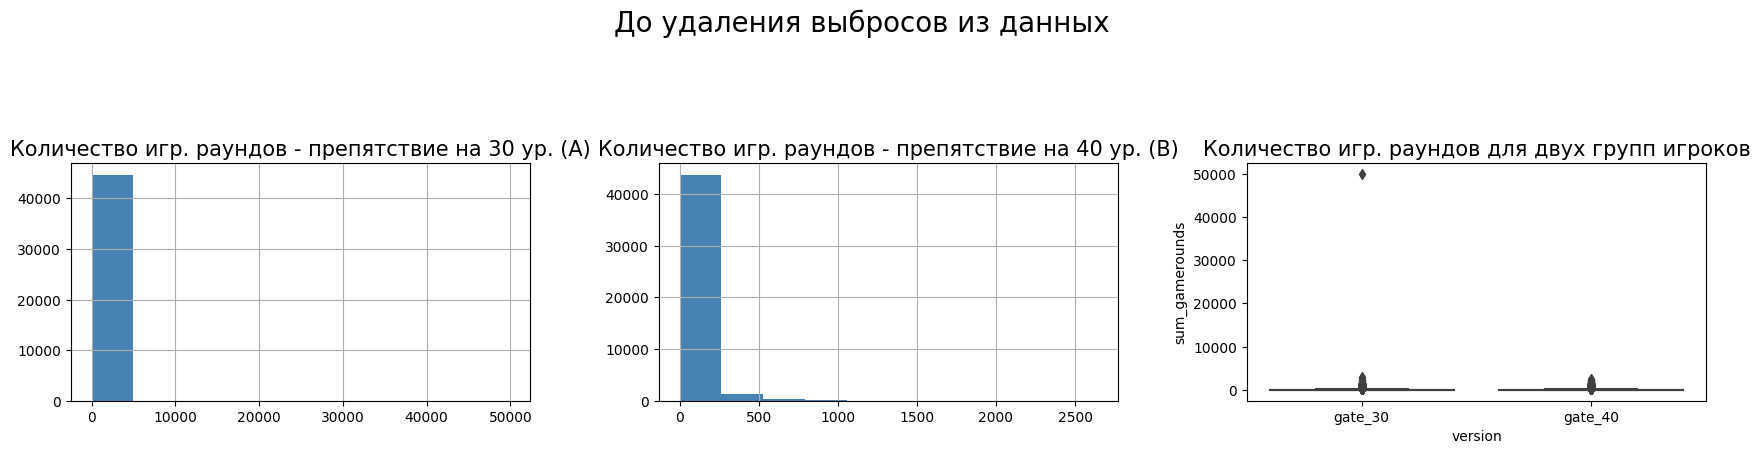

In [188]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
ab[(ab.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
ab[(ab.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = ab.version, y = ab.sum_gamerounds, ax = axes[2])

plt.suptitle("До удаления выбросов из данных", fontsize = 20)
axes[0].set_title("Количество игр. раундов - препятствие на 30 ур. (A)", fontsize = 15)
axes[1].set_title("Количество игр. раундов - препятствие на 40 ур. (B)", fontsize = 15)
axes[2].set_title("Количество игр. раундов для двух групп игроков", fontsize = 15)

plt.tight_layout(pad = 4);

In [189]:
ab = ab[ab.sum_gamerounds < ab.sum_gamerounds.max()]

#Сводная статистика по sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0,51.320253,102.682719,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,2961.0


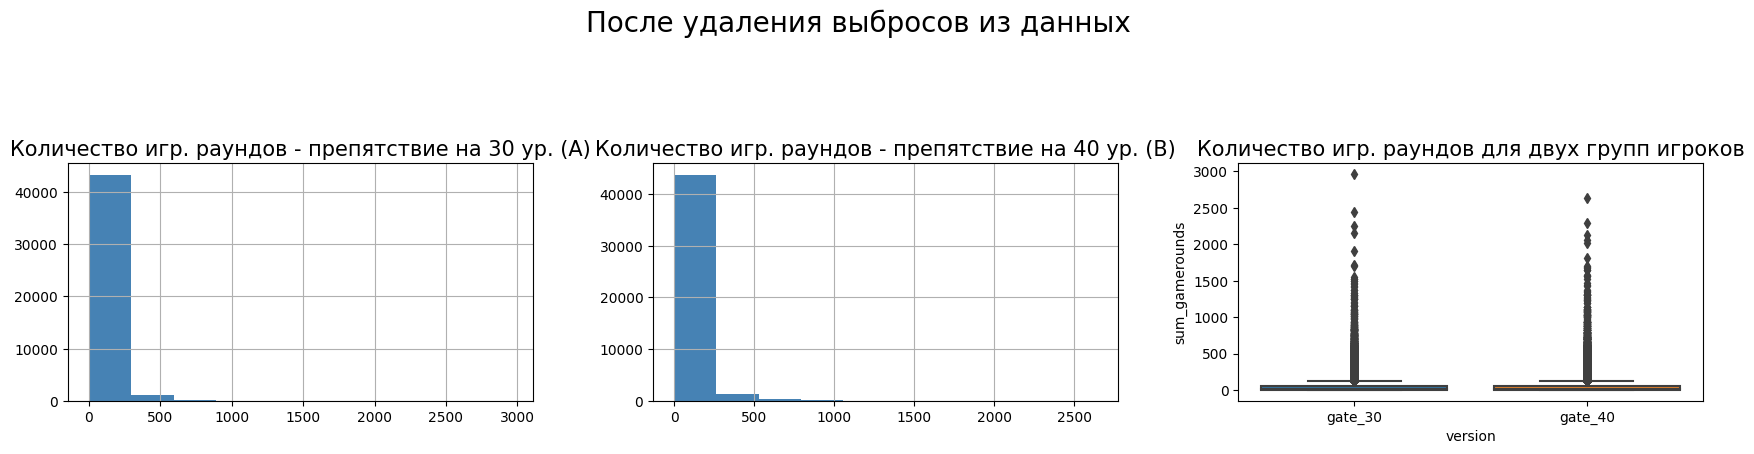

In [190]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
ab[(ab.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
ab[(ab.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = ab.version, y = ab.sum_gamerounds, ax = axes[2])

plt.suptitle("После удаления выбросов из данных", fontsize = 20)
axes[0].set_title("Количество игр. раундов - препятствие на 30 ур. (A)", fontsize = 15)
axes[1].set_title("Количество игр. раундов - препятствие на 40 ур. (B)", fontsize = 15)
axes[2].set_title("Количество игр. раундов для двух групп игроков", fontsize = 15)

plt.tight_layout(pad = 4);

In [191]:
#Как много пользователей достигают препятствий на уровнях 30 и 40 игры
ab.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [192]:
#исследуем статистику для групп (максимальные значения теперь уже не отличаются в разы).
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


In [193]:
#A/B-тестирование
#H0 - группы А и B однородны
#H1 - группы А и B не однородны
#Для проверки не отвергается ли H0:
#Разделить данные на контрольную и тестовую группы
#Применить тест Шапиро-Уилка для проверки нормального распределения групп.
#Если у обеих групп нормальное распределение, то применяем параметрический тест, иначе непараметрический
#Если параметрический, применяем тест Левена на однородность дисперсий.
#Если параметрический + однородность дисперсий, применяем t- критерий Стьюдента
#Если параметрический - однородность дисперсий, применяем t- критерий Уэлча.
#Если непараметрический, применяем напрямую U-критерий Манна-Уитни.

In [194]:
ab["version"] = np.where(ab.version == "gate_30", "A", "B")
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


In [196]:
#Функция для A/B тестирования
def AB_Test(dataframe, group, target):
    from scipy.stats import shapiro
    import scipy.stats as stats

    # Разделение по группам A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]

    # Проверка нормального распределения групп
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Распределение является нормальным. - False
    # H1: Распределение не является нормальным! - True

    if (ntA == False) & (ntB == False): # "H0 не отвергается"
        # Тип теста -параметрический
        # Проверяем однородность дисперсии
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Однородна: False
        # H1: Неоднородна: True

        if leveneTest == False:
            # Однородна
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Неоднородна
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Тип теста - непараметрический
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True

    #Результат
    temp = pd.DataFrame({
        "AB гипотезы":[ttest < 0.05],
        "p-значение":[ttest]
    })
    temp["тип теста"] = np.where((ntA == False) & (ntB == False), "Параметрическая", "Непараметрическая")
    temp["AB гипотезы"] = np.where(temp["AB гипотезы"] == False, "H0 не отвергается", "H0 отвергается")
    temp["вывод"] = np.where(temp["AB гипотезы"] == "H0 не отвергается", "A/B группы похожи!", "A/B группы не похожи!")

    # Columns
    if (ntA == False) & (ntB == False):
        temp["однородность"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["тип теста", "однородность","AB гипотезы", "p-значение", "вывод"]]
    else:
        temp = temp[["тип теста","AB гипотезы", "p-значение", "вывод"]]

    # Print Hypothesis
    print("# A/B  тестирование")
    print("H0: A == B")
    print("H1: A != B", "\n")

    return temp

In [197]:
#A/B тестирование
AB_Test(dataframe=ab, group = "version", target = "sum_gamerounds")
#H0: A == B (группы A и B похожи - соответствующие выборки однородны)
#H1: A != B (группы A и B не похожи - выборки разные)

# A/B  тестирование
H0: A == B
H1: A != B 



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,тип теста,AB гипотезы,p-значение,вывод
0,Непараметрическая,H0 не отвергается,0.050892,A/B группы похожи!


Таким образом гипотеза H0 не отвергается и значит, перемещение препятствия с 30 на 40 уровень игры не повлияло на количество
 сыгранных игроками раундов игры.